In [2]:
import sys
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from PIL import Image
from tqdm import tqdm
from sklearn import metrics
import pandas as pd
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import mobilenet,mobilenet_v2,inception_v3,efficientnet
import tensorflow_model_optimization as tfmot

In [3]:
def Evaluate(model: keras.engine.sequential.Sequential):
    print("Evalutions... ", "\n", 
      "Train -> ", model.evaluate(X_train, y_train), "\n",
      "Test -> ", model.evaluate(X_test, y_test), "\n",
      "Validation -> ", model.evaluate(X_val, y_val))

def SizeOfNet(model: bytes):
    print("Size -->", len(model), "bytes")
    return len(model)

In [4]:
dataset=pd.read_csv(r'C:\Users\nikita\X-RAY\sample_labels.csv')
dataset


# number of findings

dataset['Finding Labels'].value_counts()


# define categories and separate them ->

diagnosis=np.array(dataset['Finding Labels'])
deseases=[]

for i in range(len(diagnosis)):
    splitter=diagnosis[i].split("|")
    if len(splitter)==1:
            deseases.append(splitter)
    else:
        lab=[]
        for j in range(len(splitter)):
            lab.append(splitter[j])
        deseases.append(lab)
print('Numer of findings =',len(deseases))

Numer of findings = 5606


100%|██████████████████████████████████████████████████████████████████████████████| 5606/5606 [01:07<00:00, 82.80it/s]


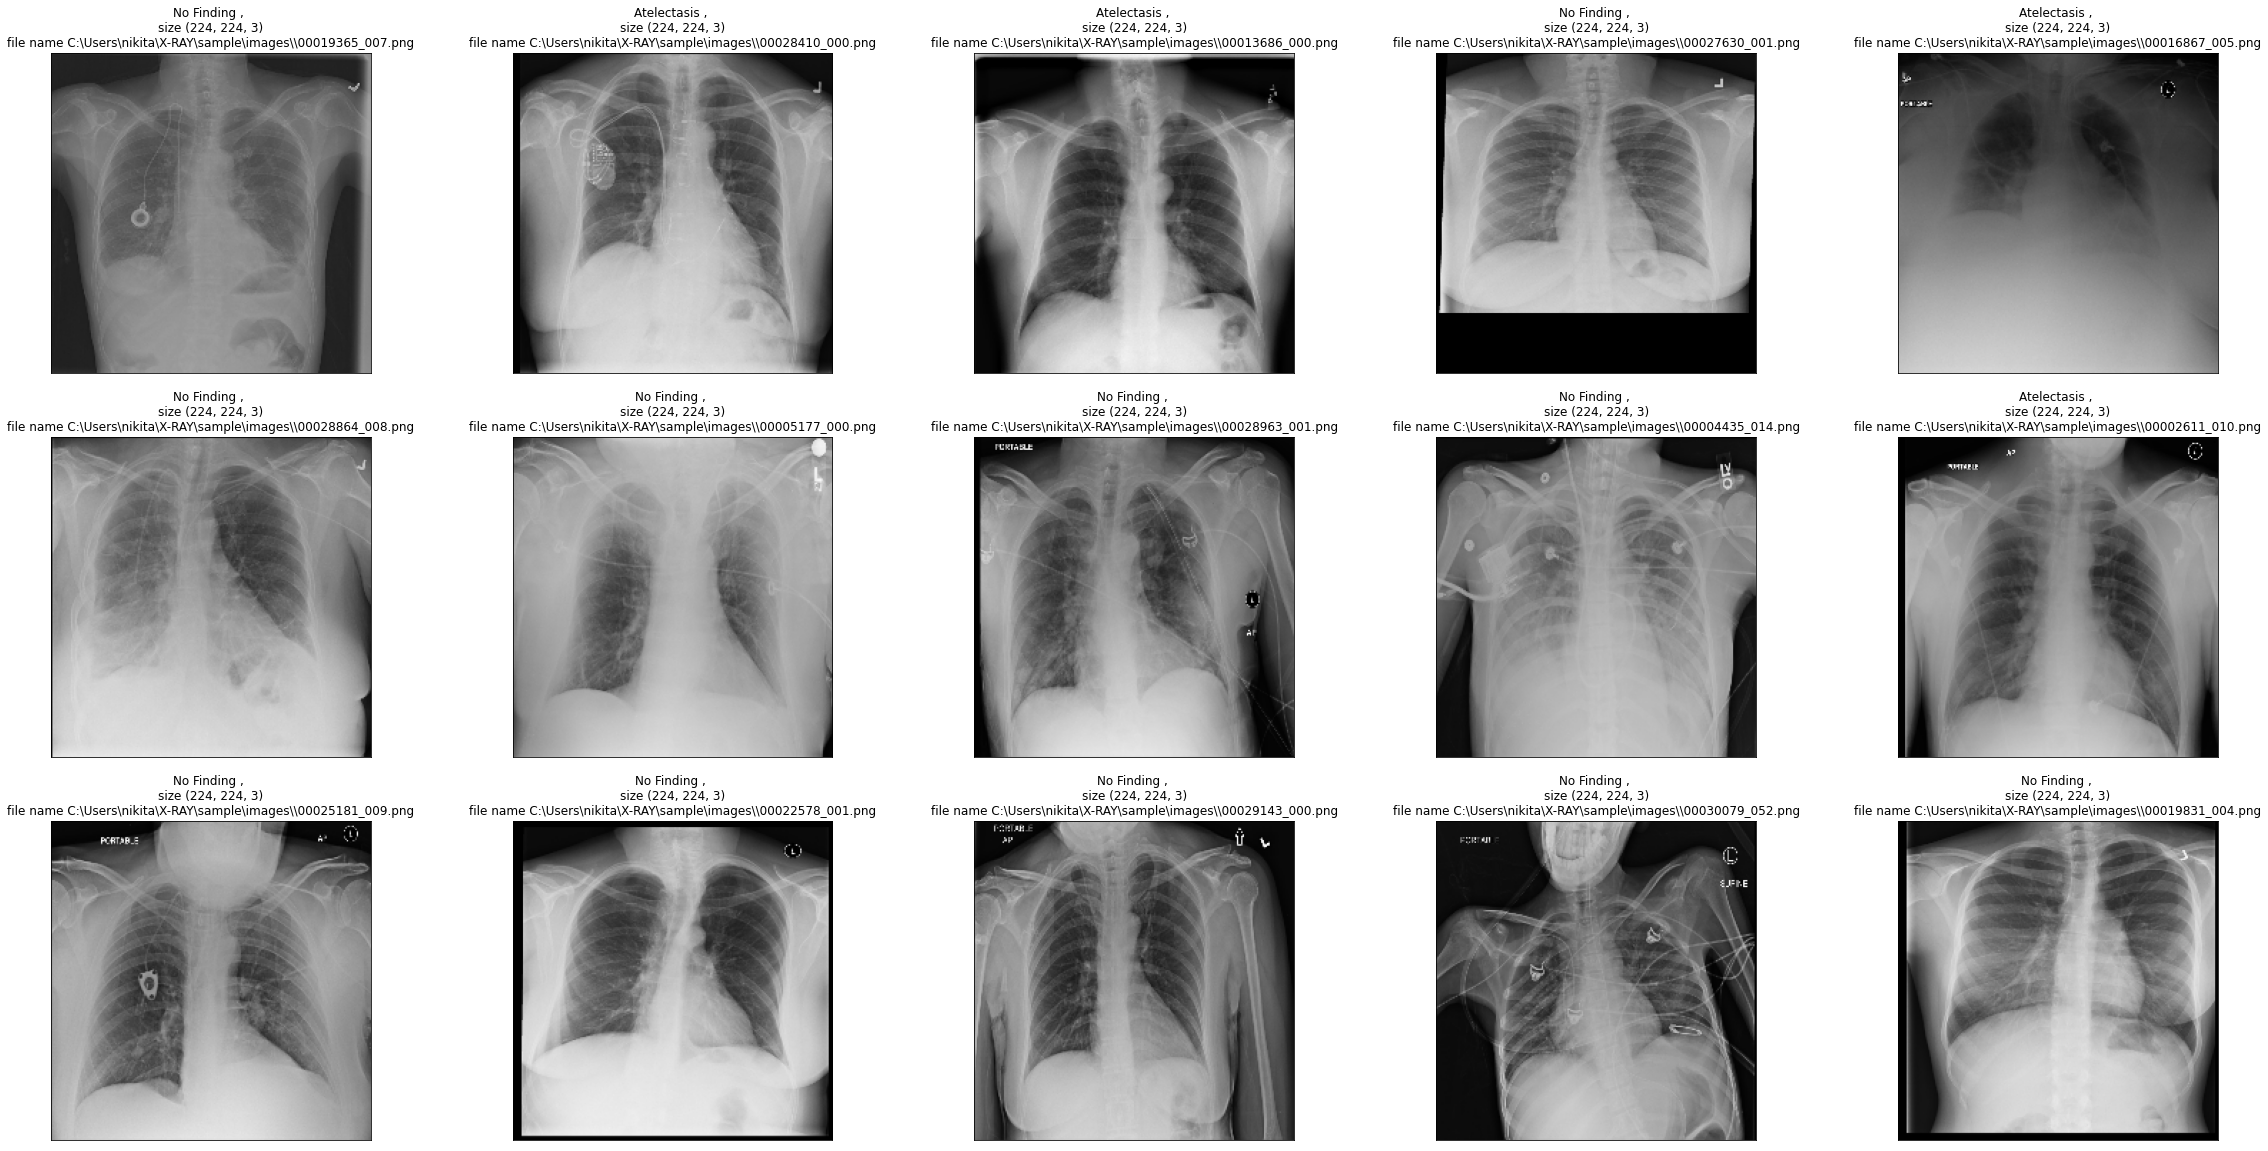

In [5]:
img_size=224
source=r'C:\Users\nikita\X-RAY\sample\images\\'
labels=[]
scans=[]
file = []

for i in tqdm(range(len(dataset["Image Index"]))):
    img=cv2.imread(source+dataset["Image Index"][i])
    if len(img.shape)>2: # to save images as (heigth , width, 3) rather than (hieght , width ,4)
        resize_img=cv2.resize(img,(img_size,img_size)) 
        scans.append(resize_img[:,:,:4])
    else :
        img=np.dstack([img] * 3)
        resize_img=cv2.resize(img,(img_size,img_size)) 
        scans.append(resize_img)
    file.append(source+dataset["Image Index"][i])


def img_show(data,deseases,number_of_image):
    order=np.random.randint(0,len(data),number_of_image)
    plt.figure(figsize=(40,20))
    j = int(number_of_image/5)
    for _,i in enumerate(order):
        plt.subplot(j,5,_+1)
        plt.imshow(data[i] , cmap="gray")
        label=""
        if i < len(deseases):
            for x in deseases[i]:
                label+=x+" , "

            
        plt.title(label+"\n"+f"size {data[i].shape}"+ "\n"+
                 f"file name {file[i]}")
        #to remove the number that appear around image
        plt.xticks([]),plt.yticks([])
    plt.show()


img_show(scans, deseases, 15)

In [6]:
classes={
0:"Hernia",
1:"Pneumonia",
2:"Fibrosis",
3:"Edema",
4:"Emphysema",
5:"Cardiomegaly",
6:"Pleural_Thickening",
7:"Consolidation",
8:"Pneumothorax",
9:"Mass",
10:"Nodule",
11:"Atelectasis",
12:"Effusion",
13:"Infiltration",
14:"No Finding",
}

def getter_class(code):
    return classes[code]

def getter_code(labels):
    for key,value  in classes.items():
        if value ==labels:
            return key

In [7]:
scans = np.array(scans)

for i in tqdm(range(len(deseases))):
    deseases[i]=[getter_code(x) for x in deseases[i]]
        

deseases


from sklearn.preprocessing import MultiLabelBinarizer
mlp=MultiLabelBinarizer()
Labels=mlp.fit_transform(deseases)
Labels = np.array(Labels)
scans.shape

deseases

100%|██████████████████████████████████████████████████████████████████████████| 5606/5606 [00:00<00:00, 702727.68it/s]


[[4, 13, 6, 8],
 [5, 4],
 [14],
 [11],
 [5, 3, 12],
 [7, 9],
 [14],
 [14],
 [12],
 [14],
 [7, 12, 13, 10],
 [9],
 [14],
 [14],
 [12],
 [12],
 [12],
 [14],
 [9, 8],
 [5, 7],
 [7],
 [5, 7],
 [5, 7],
 [8],
 [14],
 [12],
 [7, 6],
 [13, 10],
 [14],
 [11],
 [11],
 [2],
 [13],
 [13],
 [14],
 [14],
 [14],
 [14],
 [2],
 [14],
 [7],
 [4],
 [14],
 [14],
 [13],
 [7, 9],
 [14],
 [11, 13, 9, 6],
 [13],
 [14],
 [14],
 [13],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [13, 10],
 [14],
 [4],
 [14],
 [13],
 [14],
 [14],
 [8],
 [4, 9],
 [14],
 [14],
 [14],
 [14],
 [14],
 [5, 4],
 [14],
 [14],
 [14],
 [14],
 [14],
 [13],
 [8],
 [4, 8],
 [4, 13],
 [14],
 [14],
 [14],
 [14],
 [13],
 [7, 12, 13],
 [7, 2],
 [14],
 [2, 6],
 [14],
 [14],
 [14],
 [12, 13],
 [2],
 [14],
 [14],
 [14],
 [10],
 [10],
 [9, 6],
 [13, 6],
 [12, 13],
 [14],
 [14],
 [14],
 [9],
 [14],
 [14],
 [14],
 [14],
 [14],
 [9],
 [12],
 [14],
 [14],
 [11],
 [14],
 [6],
 [14],
 [14],
 [14],
 [4],
 [14],
 [14],
 [14],
 [2],
 [14],
 [12],
 [14],

In [8]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import accuracy_score
#split to train and test
X_train, y_train, X_test, y_test = iterative_train_test_split(scans, Labels, test_size = 0.3)
#split to valid and test
X_val, y_val, X_test, y_test = iterative_train_test_split(X_test, y_test, test_size = 0.5)

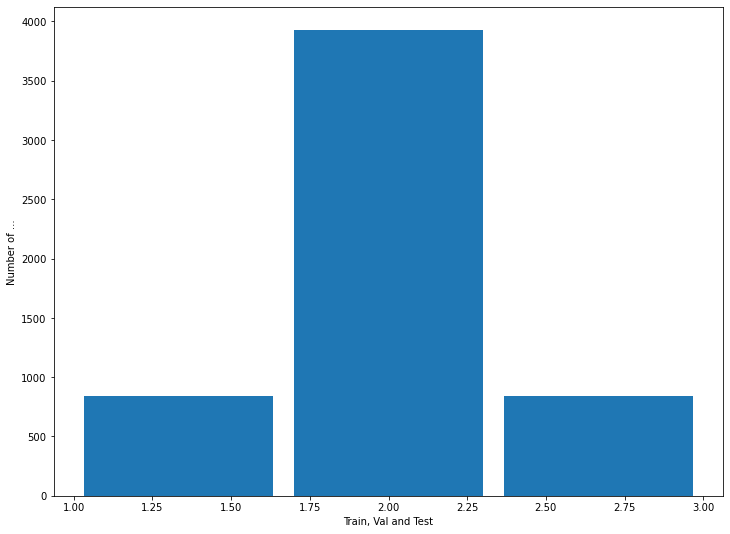

In [9]:
import seaborn as sns
def show_destribution():
    x_axes = np.arange(3)
    y_axes = []
    for train_el in X_train:
        y_axes.append(2)
    for val_el in X_val:
        y_axes.append(1)
    for test_el in X_test:
        y_axes.append(3)
    
    fig = plt.figure(figsize=(12, 9))
    plt.hist(x=y_axes, bins=3, zorder=2, rwidth=0.9)
    plt.xlabel('Train, Val and Test')
    plt.ylabel('Number of ...')
    
show_destribution()

In [10]:
print("input 1 for mobile_net, 2 for resnet, 3 for Xception ", end='')

choice = int(input())

if (choice == 1):
    my_model = keras.Sequential()
    model_general=tf.keras.applications.MobileNet(include_top=True, input_shape=(224, 224, 3))
    
    for layer in model_general.layers[:-1]:
        my_model.add(layer)

    my_model.add(keras.layers.Dense(15, activation=keras.activations.softmax))
    
    for l in my_model.layers[:-1]:
        l.trainable = False
elif (choice == 2):
    model_general=tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3))
    
    last_l = model_general.output
    last_l = tf.keras.layers.GlobalAveragePooling2D()(last_l)
    last_l = tf.keras.layers.Dense(1024, activation='relu')(last_l)
    predictions_resnet = tf.keras.layers.Dense(15, activation="softmax")(last_l)
    my_model = tf.keras.Model(model_general.input, predictions_resnet)
    
    for l in my_model.layers[:-3]:
        l.trainable = False
elif (choice == 3):
    model_general=tf.keras.applications.Xception(include_top=False, input_shape=(224, 224, 3))
    
    last_l = model_general.output
    last_l = tf.keras.layers.GlobalAveragePooling2D()(last_l)
    last_l = tf.keras.layers.Dense(1024, activation='relu')(last_l)
    predictions_resnet = tf.keras.layers.Dense(15, activation="softmax")(last_l)
    my_model = tf.keras.Model(model_general.input, predictions_resnet)
    
    for l in my_model.layers[:-3]:
        l.trainable = False
else:
    print("!wrong input")

input 1 for mobile_net, 2 for resnet, 3 for Xception 2


In [11]:
model_general.summary(), my_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block4_1_relu[0][0]']    
                                                                                                  
 conv3_block4_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_2_conv[0][0]']    
 ization)                                                                                         
          

 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)       

                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

(None, None)

In [12]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=1),
    tf.keras.callbacks.ModelCheckpoint("NIH_model_1.h5",save_best_only=True,verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=1, min_delta = 0.001,
                                      min_lr=0.000001,
                                      mode = 'min',verbose=1)]

In [13]:
my_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.binary_crossentropy,metrics=["accuracy"] )

history = my_model.fit(X_train,y_train,epochs=10, 
          batch_size=32,validation_data=(X_val, y_val),verbose=1, callbacks=callbacks)

Epoch 1/10
123/123 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.5196
Epoch 1: val_loss improved from inf to 0.20559, saving model to NIH_model_1.h5
123/123 [==============================] - 63s 112ms/step - loss: 0.2215 - accuracy: 0.5196 - val_loss: 0.2056 - val_accuracy: 0.5238 - lr: 1.0000e-04
Epoch 2/10
123/123 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.5293
Epoch 2: val_loss improved from 0.20559 to 0.20086, saving model to NIH_model_1.h5
123/123 [==============================] - 10s 83ms/step - loss: 0.1972 - accuracy: 0.5293 - val_loss: 0.2009 - val_accuracy: 0.5238 - lr: 1.0000e-04
Epoch 3/10
123/123 [==============================] - ETA: 0s - loss: 0.1906 - accuracy: 0.5359
Epoch 3: val_loss improved from 0.20086 to 0.19876, saving model to NIH_model_1.h5
123/123 [==============================] - 10s 85ms/step - loss: 0.1906 - accuracy: 0.5359 - val_loss: 0.1988 - val_accuracy: 0.5238 - lr: 1.0000e-04
Epoch 4/10
122/1

- the Accuracy and Loss for custom Model With 10 Epochs


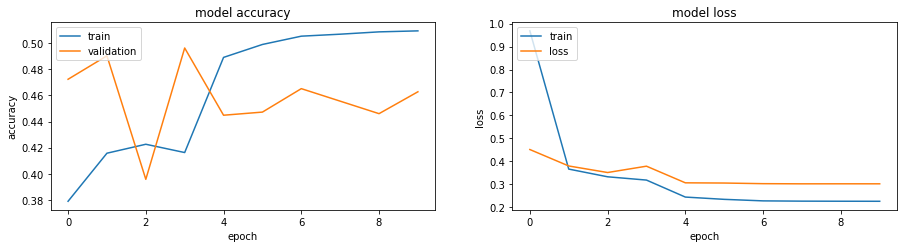

In [34]:
print("- the Accuracy and Loss for custom Model With 10 Epochs")
plt.figure(figsize=(40,20))



# summarize history for accuracy 
plt.subplot(5,5,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')



# summarize history for loss
plt.subplot(5,5,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','loss'], loc='upper left')
plt.show()

In [14]:
Evaluate(my_model)
my_model.save('./saved_models')

27/27 [==============================] - 2s 63ms/step - loss: 0.1971 - accuracy: 0.5226
Evalutions...  
 Train ->  [0.17037522792816162, 0.5626273155212402] 
 Test ->  [0.196598619222641, 0.5334128737449646] 
 Validation ->  [0.19706352055072784, 0.5226190686225891]
INFO:tensorflow:Assets written to: ./saved_models\assets


**POST-TRAINING QUANTIZATION**

In [15]:
def representative_dataset():
    for data in tf.data.Dataset.from_tensor_slices((X_train)).batch(1).take(100):
        yield [tf.dtypes.cast(data, tf.float32)]

In [16]:
converter = tf.lite.TFLiteConverter.from_saved_model('./saved_models')
# converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
my_tflite_model = converter.convert()

In [17]:
before_quant = SizeOfNet(my_tflite_model)

Size --> 102417692 bytes


In [18]:
converter = tf.lite.TFLiteConverter.from_saved_model('./saved_models')
# converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

print("Input 1 for only integer, 2 for float16, 3 for dynamic")

quant_choice = int(input())
if (quant_choice == 1):
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8
elif (quant_choice == 2):
    converter.target_spec.supported_types = [tf.float16]
elif (quant_choice == 3):
    pass
else:
    print("!Wrong input")

Input 1 for only integer, 2 for float16, 3 for dynamic
2


In [19]:
my_tflite_quant_model = converter.convert()

In [20]:
after_quant = SizeOfNet(my_tflite_quant_model)

Size --> 51244320 bytes


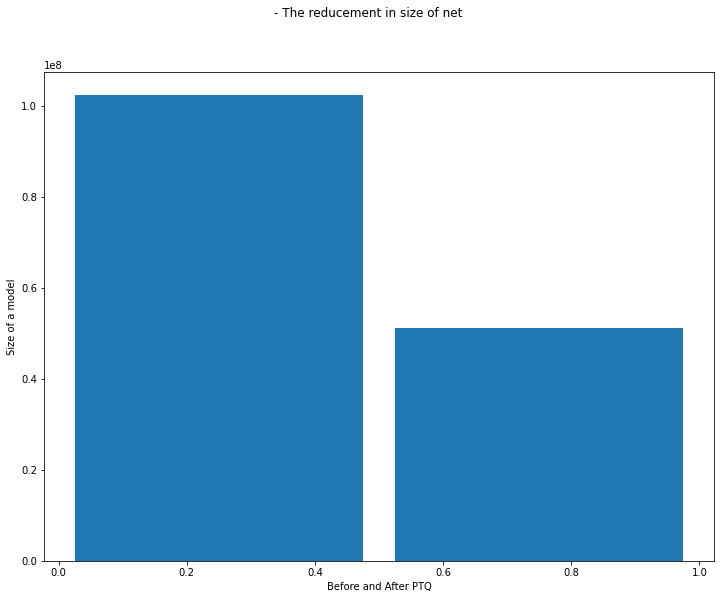

In [21]:
def reducemetn_of_size(before, after):
    plt.figure(figsize=(12,9))
    x_before = np.zeros(shape=(1, before))
    x_after = np.ones(shape=(1, after))
    
    x_axes = np.append(x_before, x_after)
    plt.hist(x=x_axes, bins=2, zorder=2, rwidth=0.9)
    plt.xlabel('Before and After PTQ')
    plt.ylabel('Size of a model')
    plt.suptitle("- The reducement in size of net")
    
reducemetn_of_size(before_quant, after_quant)

In [22]:
with open("my_tflite_model.tflite", "wb") as f:
    f.write(my_tflite_model)

In [23]:
with open("my_tflite_quant_model.tflite", "wb") as f:
    f.write(my_tflite_quant_model)

In [24]:
interpreter = tf.lite.Interpreter(model_path='my_tflite_model.tflite')

**QUANTIZATION AWARE TRAINING**

In [62]:
quantize_model = tfmot.quantization.keras.quantize_model

q_aware_model = quantize_model(my_model)

q_aware_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.binary_crossentropy,metrics=["accuracy"] )

q_aware_model.fit(X_train,y_train,epochs=5, 
          batch_size=32,validation_data=(X_val, y_val),verbose=1, callbacks=callbacks)

q_aware_model.summary()

Epoch 1/5
 38/123 [========>.....................] - ETA: 27s - loss: 0.3635 - accuracy: 0.4646

KeyboardInterrupt: 

In [ ]:
Evaluate(q_aware_model)

**PRUNING**

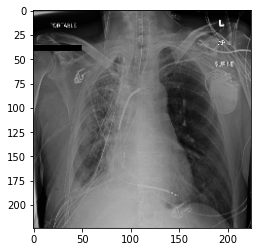

In [57]:
plt.imshow(X_train[0])

In [60]:
print('Choose percentage of pruning...')
pruning_choice = int(input()) / 100

batch_size = 32
epochs = 10
end_step = np.ceil(len(X_train) / batch_size).astype(np.int32) * epochs
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                       final_sparsity=pruning_choice,
                                                       begin_step=0,
                                                       end_step=end_step)

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(my_model, pruning_schedule=pruning_schedule)

Choose per cent of pruning...
68


C:\Users\nikita\AppData\Roaming\Python\Python39\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  mask = self.add_variable(
C:\Users\nikita\AppData\Roaming\Python\Python39\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  threshold = self.add_variable(
C:\Users\nikita\AppData\Roaming\Python\Python39\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.pruning_step = self.add_variable(


In [61]:
model_for_pruning.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.binary_crossentropy,metrics=["accuracy"] )

model_for_pruning.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 prune_low_magnitude_block1_con  (None, 111, 111, 32  1730       ['input_8[0][0]']                
 v1 (PruneLowMagnitude)         )                                                                 
                                                                                                  
 prune_low_magnitude_block1_con  (None, 111, 111, 32  129        ['prune_low_magnitude_block1_conv
 v1_bn (PruneLowMagnitude)      )                                1[0][0]']                  

 uneLowMagnitude)                                                [0][0]',                         
                                                                  'prune_low_magnitude_batch_norma
                                                                 lization_25[0][0]']              
                                                                                                  
 prune_low_magnitude_block4_sep  (None, 28, 28, 256)  1          ['prune_low_magnitude_add_73[0][0
 conv1_act (PruneLowMagnitude)                                   ]']                              
                                                                                                  
 prune_low_magnitude_block4_sep  (None, 28, 28, 728)  375042     ['prune_low_magnitude_block4_sepc
 conv1 (PruneLowMagnitude)                                       onv1_act[0][0]']                 
                                                                                                  
 prune_low

                                                                                                  
 prune_low_magnitude_block6_sep  (None, 14, 14, 728)  2913       ['prune_low_magnitude_block6_sepc
 conv2_bn (PruneLowMagnitude)                                    onv2[0][0]']                     
                                                                                                  
 prune_low_magnitude_block6_sep  (None, 14, 14, 728)  1          ['prune_low_magnitude_block6_sepc
 conv3_act (PruneLowMagnitude)                                   onv2_bn[0][0]']                  
                                                                                                  
 prune_low_magnitude_block6_sep  (None, 14, 14, 728)  1066522    ['prune_low_magnitude_block6_sepc
 conv3 (PruneLowMagnitude)                                       onv3_act[0][0]']                 
                                                                                                  
 prune_low

 conv1_act (PruneLowMagnitude)                                   ]']                              
                                                                                                  
 prune_low_magnitude_block9_sep  (None, 14, 14, 728)  1066522    ['prune_low_magnitude_block9_sepc
 conv1 (PruneLowMagnitude)                                       onv1_act[0][0]']                 
                                                                                                  
 prune_low_magnitude_block9_sep  (None, 14, 14, 728)  2913       ['prune_low_magnitude_block9_sepc
 conv1_bn (PruneLowMagnitude)                                    onv1[0][0]']                     
                                                                                                  
 prune_low_magnitude_block9_sep  (None, 14, 14, 728)  1          ['prune_low_magnitude_block9_sepc
 conv2_act (PruneLowMagnitude)                                   onv1_bn[0][0]']                  
          

                                                                                                  
 prune_low_magnitude_block11_se  (None, 14, 14, 728)  1066522    ['prune_low_magnitude_block11_sep
 pconv3 (PruneLowMagnitude)                                      conv3_act[0][0]']                
                                                                                                  
 prune_low_magnitude_block11_se  (None, 14, 14, 728)  2913       ['prune_low_magnitude_block11_sep
 pconv3_bn (PruneLowMagnitude)                                   conv3[0][0]']                    
                                                                                                  
 prune_low_magnitude_add_81 (Pr  (None, 14, 14, 728)  1          ['prune_low_magnitude_block11_sep
 uneLowMagnitude)                                                conv3_bn[0][0]',                 
                                                                  'prune_low_magnitude_add_80[0][0
          

 prune_low_magnitude_block14_se  (None, 7, 7, 1536)  1           ['prune_low_magnitude_block14_sep
 pconv1_act (PruneLowMagnitude)                                  conv1_bn[0][0]']                 
                                                                                                  
 prune_low_magnitude_block14_se  (None, 7, 7, 2048)  6305282     ['prune_low_magnitude_block14_sep
 pconv2 (PruneLowMagnitude)                                      conv1_act[0][0]']                
                                                                                                  
 prune_low_magnitude_block14_se  (None, 7, 7, 2048)  8193        ['prune_low_magnitude_block14_sep
 pconv2_bn (PruneLowMagnitude)                                   conv2[0][0]']                    
                                                                                                  
 prune_low_magnitude_block14_se  (None, 7, 7, 2048)  1           ['prune_low_magnitude_block14_sep
 pconv2_ac

In [62]:
import tempfile

logdir = tempfile.mkdtemp()

prune_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=1),
    tf.keras.callbacks.ModelCheckpoint("NIH_model_1.h5",save_best_only=True,verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=1, min_delta = 0.001,
                                      min_lr=0.000001,
                                      mode = 'min',verbose=1),
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(X_train, y_train,
                  batch_size=batch_size, epochs=epochs,validation_data=(X_val, y_val),verbose=1,
                  callbacks=prune_callbacks)

Epoch 1/10
123/123 [==============================] - ETA: 0s - loss: 0.3722 - accuracy: 0.4160
Epoch 1: val_loss improved from inf to 0.45406, saving model to NIH_model_1.h5
123/123 [==============================] - 48s 147ms/step - loss: 0.3722 - accuracy: 0.4160 - val_loss: 0.4541 - val_accuracy: 0.3669 - lr: 1.0000e-04
Epoch 2/10
123/123 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.3997
Epoch 2: val_loss did not improve from 0.45406

Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
123/123 [==============================] - 16s 133ms/step - loss: 0.5185 - accuracy: 0.3997 - val_loss: 0.7722 - val_accuracy: 0.4856 - lr: 1.0000e-04
Epoch 3/10
123/123 [==============================] - ETA: 0s - loss: 0.5088 - accuracy: 0.3788
Epoch 3: val_loss did not improve from 0.45406

Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-06.
123/123 [==============================] - 16s 131ms/step - loss: 0.5088 - accuracy: 0.3788 - val_l

In [ ]:
Evaluate(model_for_pruning)